In [1]:
import os
import sys
from glob import glob

import numpy as np
import pandas as pd
import xarray as xr
import rioxarray
import rasterio as rio

import geopandas as gpd
from shapely.geometry import Point
from pyproj import CRS

from sklearn.metrics import r2_score
from scipy.stats import gaussian_kde

import matplotlib
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize
from matplotlib.dates import DayLocator
import matplotlib.dates as mdates
from matplotlib.ticker import FuncFormatter
from mpl_toolkits.axes_grid1 import axes_grid


# Add custom script path
sys.path.append('/home/mosfran/Documents/scripts/tools')
from hydro.stats import *

# Function to flatten DataArray and remove NaNs
def flatDA(da):
    da_flat = da.values.flatten()
    return da_flat[np.isfinite(da_flat)]


In [2]:
# Function to flatten DataArray and remove NaNs
def flatDA(da):
    da_flat = da.values.flatten()
    return da_flat[np.isfinite(da_flat)]
def get_CDF_data(data):
    # sort the data
    data_sorted = np.sort(data)
    # calculate the proportional values of sample
    p = 1. * np.arange(len(data)) / (len( data) - 1)

    return data_sorted,p
def my_formatter(x, pos):
    if x.is_integer():
        return str(int(x))
    else:
        return str(np.round(x,1))

In [3]:
formatter = FuncFormatter(my_formatter)
plt.rcParams['font.family'] = 'DeJavu Serif'
plt.rcParams['font.serif'] = ['Times New Roman']

In [4]:
main_dir='/eos/jeodpp/home/users/mosfran/data/po_casestudy/zenodo/'
cal_out_dir=os.path.join(main_dir,'experiments_output')
out_dir=os.path.join(main_dir,'plots')
EFAS_calib_dir='/eos/jeodpp/data/projects/LISFLOOD/Europe_1arcmin/calibration/catchments/'

#exp_names=[os.path.basename(x) for x in (glob(cal_out_dir+"*"))]
exp_names=['NOBP', 'NOBPNEWSD', 'NOBPNEWSD3', 'benchmark', 'BPNEWSD3', 'BPNEWSD']
mosaic=[['benchmark','BPNEWSD','BPNEWSD3'],['NOBP', 'NOBPNEWSD', 'NOBPNEWSD3']]
stor_dir='/storage/mosfran/po_casestudy/calibration_pp/budyko_paper'
os.makedirs(stor_dir,exist_ok=True)
summary_dict=dict.fromkeys(exp_names)


In [5]:
start_date='1990-01-02T06:00:00'
end_date='2021-12-31T06:00:00'

In [6]:
# create empty dictionary with keys for each experiment
etact={}
for i in exp_names:
    summary_dict[i]=etact.copy()

In [7]:
# lisflood fraction input
forest_frac=xr.load_dataset(os.path.join(main_dir,'static_input_data','fracforest.nc'))
lake_mask=xr.load_dataset(os.path.join(main_dir,'static_input_data','lakemask.nc'))
sealed_frac=xr.load_dataset(os.path.join(main_dir,'static_input_data','fracsealed.nc'))
forest_frac=xr.load_dataset(os.path.join(main_dir,'static_input_data','fracforest.nc'))
rice_frac=xr.load_dataset(os.path.join(main_dir,'static_input_data','fracrice.nc'))
wat_frac=xr.load_dataset(os.path.join(main_dir,'static_input_data','fracwater.nc'))
irr_frac=xr.load_dataset('/eos/jeodpp/home/users/mosfran/data/po_casestudy/LISFLOOD_data/static_data_LTR/maps/fracirrigated.nc')
#soil depth options
oldsd2=xr.load_dataset(os.path.join(main_dir,'static_input_data','soildepth2_o.nc'))
oldsd3=xr.load_dataset(os.path.join(main_dir,'static_input_data','soildepth3_o.nc'))
newsd2=xr.load_dataset(os.path.join(main_dir,'static_input_data','NEWsoildepth2_f.nc'))
newsd3=xr.load_dataset(os.path.join(main_dir,'static_input_data','NEWsoildepth3_f.nc'))
newsd3m2=xr.load_dataset(os.path.join(main_dir,'static_input_data','NEW3Msoildepth2_f.nc'))
newsd3m3=xr.load_dataset(os.path.join(main_dir,'static_input_data','NEW3Msoildepth3_f.nc'))
# read shapefile of calibrated subcatchments
catch_shp=(os.path.join(main_dir,'shp_files','catchments.gpkg'))
catchments=gpd.read_file(catch_shp)
catchments.index=catchments.ID

In [8]:
# import statistics previously computed
monthly_stats=pd.read_csv(os.path.join(cal_out_dir,'Performance_allexp.csv'))

In [9]:
# inport statistics for each experiments in dictionary
for e in exp_names:
    KGE_df = monthly_stats[monthly_stats['exp'] == e]
    KGE_df.index=KGE_df.ObsID
    summary_dict[e].update({'performance':KGE_df})


open forcing files

In [10]:
# forcings
# et=xr.open_mfdataset('/eos/jeodpp/home/users/mosfran/data/po_casestudy/LISFLOOD_data/forcings/et_hourly*')
# pr=xr.open_mfdataset('/eos/jeodpp/home/users/mosfran/data/po_casestudy/LISFLOOD_data/forcings/pr_hourly_*')
# pr_mean=pr['pr6'].sel(time=slice(start_date,end_date)).mean(dim='time')
# pr_mean=pr_mean.compute()
# et_mean=et['et'].sel(time=slice(start_date,end_date)).mean(dim='time')
# et_mean=et_mean.compute()
# et_mean.to_netcdf('/eos/jeodpp/home/users/mosfran/data/po_casestudy/zenodo/forcings/et_Dmean.nc')
# pr_mean.to_netcdf('/eos/jeodpp/home/users/mosfran/data/po_casestudy/zenodo/forcings/pr_Dmean.nc')
# read PET and PR mean
pr_mean=xr.open_dataset('/eos/jeodpp/home/users/mosfran/data/po_casestudy/zenodo/forcings/pr_Dmean.nc')['pr6']
et_mean=xr.open_dataset('/eos/jeodpp/home/users/mosfran/data/po_casestudy/zenodo/forcings/et_Dmean.nc')['et']

Compute input data

In [11]:
start_date='1990-01-02T06:00:00'
end_date='2021-12-31T06:00:00'

GET calibrated paramters

In [12]:
for i,e in enumerate(exp_names):
    cal_p_list=glob(os.path.join(cal_out_dir,e,'summary/parameters/*.nc'))
    for param_name in cal_p_list:
        p=os.path.basename(param_name[:-3])
        # print(p)
        param=xr.load_dataset(os.path.join(cal_out_dir,e,'summary/parameters',p +'.nc'))['Band1']

        param=param.assign_coords({'lat':lake_mask['Band1'].coords['lat'][::-1],'lon':lake_mask['Band1'].coords['lon']})


        summary_dict[e].update({p:param})
    if (e=='benchmark') or (e=='NOBP'):
        # sd2=flatDA(oldsd2['Band1'].where(condition_sealed))
        # sd3=flatDA(oldsd3['Band1'].where(condition_sealed))
        summary_dict[e].update({'sd2':oldsd2['Band1']})
        summary_dict[e].update({'sd3':oldsd3['Band1']})

    elif (e=='BPNEWSD') or (e=='NOBPNEWSD'):
        # sd2=flatDA(newsd2['__xarray_dataarray_variable__'].where(condition_sealed))
        # sd3=flatDA(newsd3['__xarray_dataarray_variable__'].where(condition_sealed))
        summary_dict[e].update({'sd2':newsd2['__xarray_dataarray_variable__']})
        summary_dict[e].update({'sd3':newsd3['__xarray_dataarray_variable__']})

    elif (e=='BPNEWSD3') or (e=='NOBPNEWSD3'):
        # sd2=flatDA(newsd3m2['__xarray_dataarray_variable__'].where(condition_sealed))
        # sd3=flatDA(newsd3m3['__xarray_dataarray_variable__'].where(condition_sealed))
        summary_dict[e].update({'sd2':newsd3m2['__xarray_dataarray_variable__']})
        summary_dict[e].update({'sd3':newsd3m3['__xarray_dataarray_variable__']})


Extract AET from all exp

In [13]:
#get etac for each exp
# ESActPixel+self.var.TaPixel+self.var.TaInterceptionAll+self.var.EvaAddM3*self.var.M3toMM
for e in exp_names:
    # if e =='benchmark':
    #     etac=etact_bench['etact'].sel(time=slice(start_date,end_date)).mean(dim="time")/30.4375
    #     etac=etac.compute()
    #     summary_dict[e].update({'etact':etac})
    # else:
    # etac=xr.load_dataset(os.path.join(cal_out_dir,e,'summary/long_term_run/etact.nc')).sel(time=slice(start_date,end_date))
    # etac_mean=etac['etact'].mean(dim="time")*4
    # etac_mean=etac_mean.compute()
    # etac_mean.to_netcdf(os.path.join(cal_out_dir,e,'summary/long_term_run/etac_Dmean.nc'))
    etac_mean=xr.load_dataset(os.path.join(cal_out_dir,e,'summary/long_term_run/etac_Dmean.nc'))
    summary_dict[e].update({'etact':etac_mean['etact']})
for e in exp_names:

    # ttoc=xr.load_dataset(os.path.join(cal_out_dir,e,'summary/long_term_run/ttoc.nc')).sel(time=slice(start_date,end_date))
    # ttoc_mean=ttoc['ttoc'].mean(dim="time")*4
    # ttoc_mean=ttoc_mean.compute()
    # ttoc_mean.to_netcdf(os.path.join(cal_out_dir,e,'summary/long_term_run/ttoc_Dmean.nc'))
    ttoc_mean=xr.load_dataset(os.path.join(cal_out_dir,e,'summary/long_term_run/ttoc_Dmean.nc'))
    summary_dict[e].update({'ttoc':ttoc_mean['ttoc']})
for e in exp_names:
    # gwl=xr.load_dataset(os.path.join(cal_out_dir,e,'summary/long_term_run/gwl.nc')).sel(time=slice(start_date,end_date))
    # gwl_mean=gwl['gwl'].mean(dim="time")*4
    # gwl_mean=gwl_mean.compute()
    # gwl_mean.to_netcdf(os.path.join(cal_out_dir,e,'summary/long_term_run/gwl_Dmean.nc'))
    gwl_mean=xr.load_dataset(os.path.join(cal_out_dir,e,'summary/long_term_run/gwl_Dmean.nc'))
    summary_dict[e].update({'gwl':gwl_mean['gwl']})

In [14]:
# remove gwl from precipitaiton
for e in exp_names:
    # esact=xr.load_dataset(os.path.join(cal_out_dir,e,'summary/long_term_run/esact.nc')).sel(time=slice(start_date,end_date))
    # esact_mean=esact['esact'].mean(dim="time")*4
    # esact_mean=esact_mean.compute()
    # esact_mean.to_netcdf(os.path.join(cal_out_dir,e,'summary/long_term_run/esact_Dmean.nc'))
    prec_noGWL=pr_mean-summary_dict[e]['gwl']
    summary_dict[e].update({'prec_net':prec_noGWL})

create mask

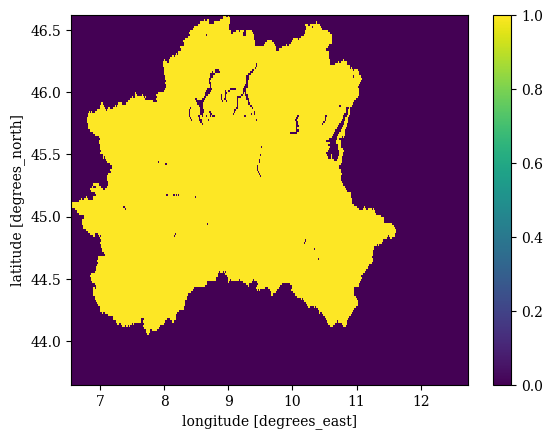

In [15]:
condition_lis=(np.isnan(summary_dict['BPNEWSD']['etact'])).compute()
condition=(condition_lis==False) & (lake_mask['Band1']==False)
condition.plot()


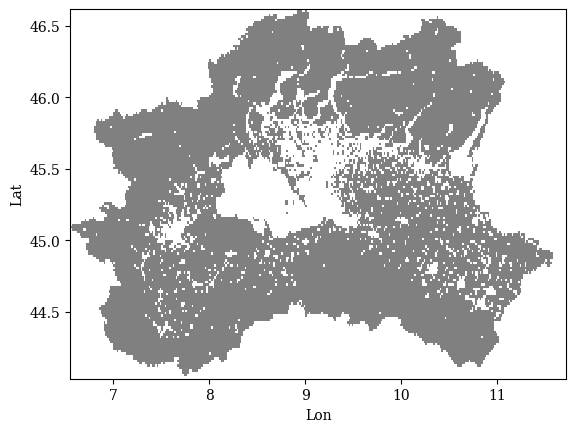

In [16]:
fig,ax = plt.subplots()
condition_lis=(np.isnan(summary_dict['BPNEWSD']['etact'])).compute()
condition=(condition_lis==False) & (lake_mask['Band1']==False)
condition_sealed=(condition==True) & (sealed_frac['Band1']<0.2) #<0.2 for paper
condition_sealed=(condition_sealed==True) & (wat_frac['Band1']<0.2) #<0.2 for paper
condition_sealed=(condition_sealed==True) & (irr_frac['Band1']==0)
condition_sealed=(condition_sealed==True) & (rice_frac['Band1']==0)
(condition_sealed*-1).isel(lon=slice(0,310),lat=slice(0,155)).plot(ax=ax,levels=2,colors=['grey','white'],add_colorbar=False)
ax.set_xlabel('Lon');
ax.set_ylabel('Lat');
fig.savefig(os.path.join(out_dir,'mask.png'), bbox_inches="tight")

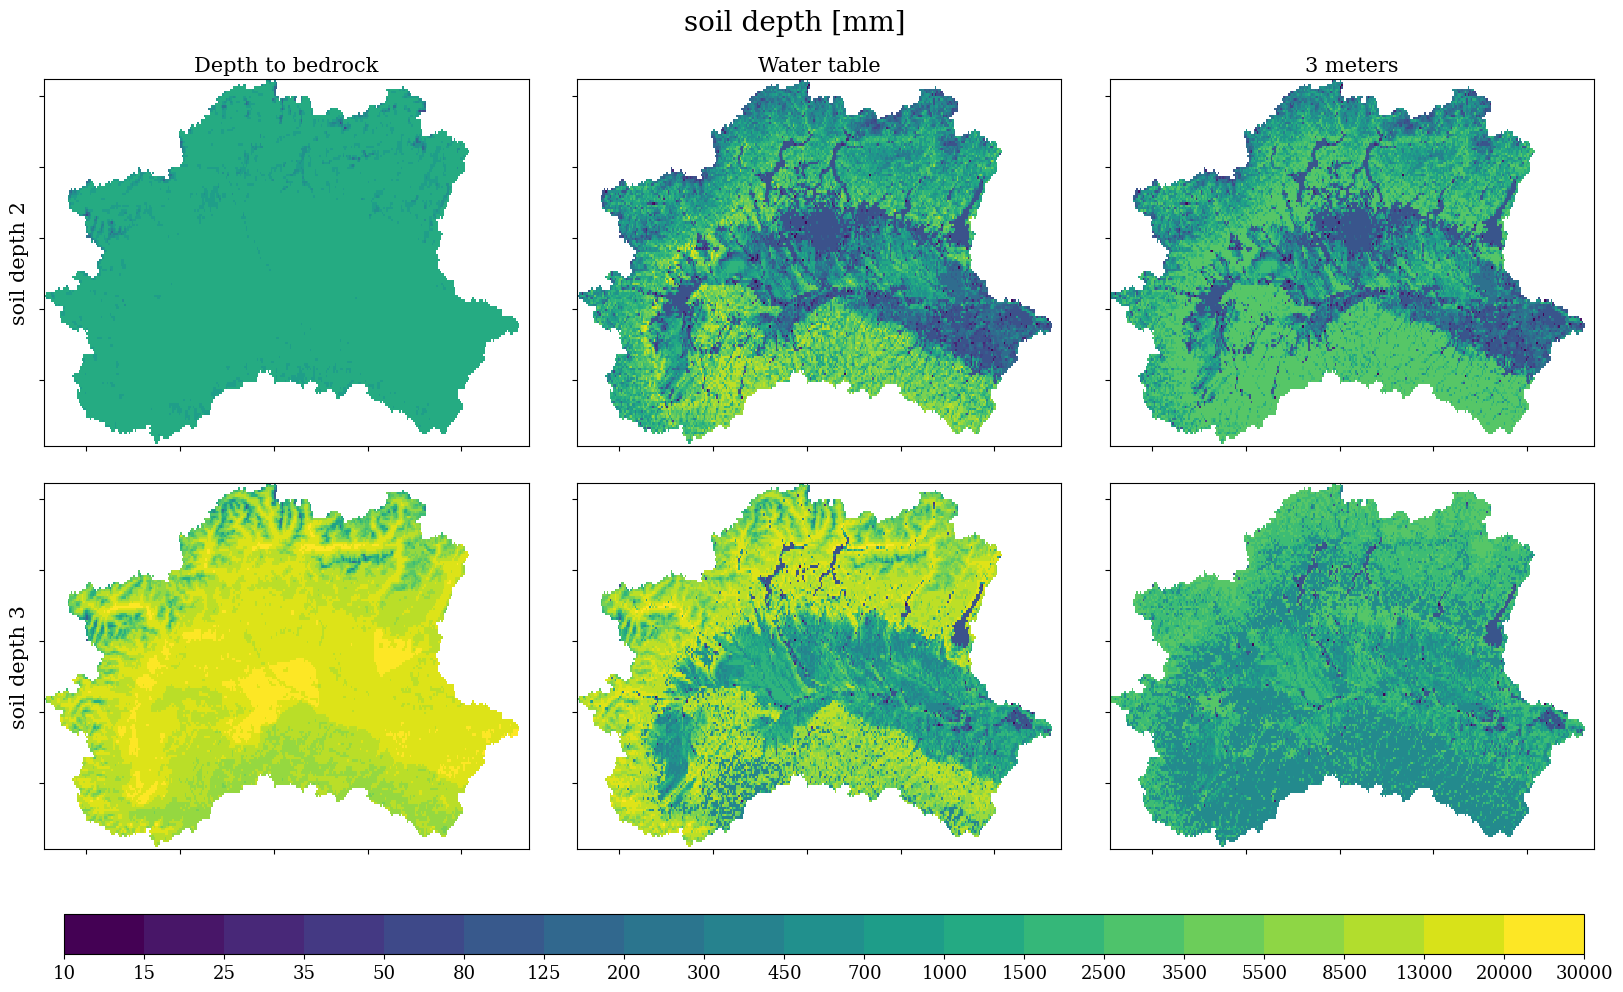

In [17]:
min_z=10
max_z=30000
# np.geomspace(10, 30000,num=20, endpoint=True,dtype=int)
levels=[10,15,25,35,50,80,125,200,300,450,700,1000,1500,2500,3500,5500,8500,13000,20000,30000]
norm = matplotlib.colors.BoundaryNorm(levels,256)

fig,ax=plt.subplots(2,3, figsize=(20, 10))
oldsd2['Band1'].where(~condition_lis).isel(lon=slice(0,310),lat=slice(0,155)).plot(ax=ax[0,0],add_colorbar=False,levels=levels)
oldsd3['Band1'].where(~condition_lis).isel(lon=slice(0,310),lat=slice(0,155)).plot(ax=ax[1,0],add_colorbar=False,levels=levels)
newsd2['__xarray_dataarray_variable__'].where(~condition_lis).isel(lon=slice(0,310),lat=slice(0,155)).plot(ax=ax[0,1],add_colorbar=False,levels=levels)
newsd3['__xarray_dataarray_variable__'].where(~condition_lis).isel(lon=slice(0,310),lat=slice(0,155)).plot(ax=ax[1,1],add_colorbar=False,levels=levels)
newsd3m2['__xarray_dataarray_variable__'].where(~condition_lis).isel(lon=slice(0,310),lat=slice(0,155)).plot(ax=ax[0,2],add_colorbar=False,levels=levels)
newsd3m3['__xarray_dataarray_variable__'].where(~condition_lis).isel(lon=slice(0,310),lat=slice(0,155)).plot(ax=ax[1,2],add_colorbar=False,levels=levels)
# sdcalib2['Band1'].where(~condition_lis.values[::-1,:]).plot(ax=ax[0,3],add_colorbar=False,levels=levels)
# sdcalib3['Band1'].where(~condition_lis.values[::-1,:]).plot(ax=ax[1,3],add_colorbar=False,levels=levels)
fig.suptitle('soil depth [mm]', y=0.95,size=20)
cbar=fig.add_axes([0.135,0.005,0.76,0.04])

plt.setp(plt.gcf().get_axes(), xlabel='', ylabel='');
    
thebar=fig.colorbar(matplotlib.cm.ScalarMappable(norm=norm),cax=cbar, orientation = "horizontal",aspect=30)
ax[0,0].set_ylabel('soil depth 2',fontdict={'size':15})
ax[1,0].set_ylabel('soil depth 3',fontdict={'size':15})

ax[0,0].set_title('Depth to bedrock',fontdict={'size':15})
ax[0,1].set_title('Water table',fontdict={'size':15})
ax[0,2].set_title('3 meters',fontdict={'size':15})


thebar.ax.tick_params(labelsize=13)
thebar.set_ticks(levels)
levels_str=[str(np.round(x,2)) for x in levels]
thebar.ax.set_xticklabels(levels_str);
plt.subplots_adjust(wspace=0.1,hspace=0.1);
plt.setp(ax, xticklabels='', yticklabels='');
fig.savefig(os.path.join(out_dir,'soil_depth.png'), bbox_inches="tight")



calculating evaporation ration and aridity index where no lake are present and urban area is below 0.6

In [18]:
#evaporation ratio (E/P) and the aridity index (Ep/P), which is a measure of the ratio of the energy available (Ep)

aridity_index=(et_mean/pr_mean)
aridity_index=aridity_index.compute()


In [19]:
for e in exp_names:
    evap_ratio=(summary_dict[e]['etact']/pr_mean)

    summary_dict[e].update({'evap_ratio':evap_ratio})

for e in exp_names:
    ttoc_ratio=(summary_dict[e]['ttoc']/pr_mean)

    summary_dict[e].update({'ttoc_ratio':ttoc_ratio})

In [20]:
x_ar=np.arange(0,2,0.001)
def budyko(x):
    return (x*np.tanh(1/x)*(1-np.exp(-x)))**(0.5)
optimal_budyko=budyko(x_ar)

/tmp/ipykernel_236139/1316548489.py:3: RuntimeWarning: divide by zero encountered in divide
  return (x*np.tanh(1/x)*(1-np.exp(-x)))**(0.5)


Budykodensityplot

In [21]:
from scipy.stats import gaussian_kde
from matplotlib import pyplot as plt
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize
from matplotlib.lines import Line2D

In [22]:
exp_title=['NOBP', 'NOBP-WT', 'NOBP-3M', 'benchmark', 'BP-3M', 'BP-WT']

In [23]:
# define mask to use to calculate budyko
mask2apply=condition_sealed
# calculate aridity index
aridity_index=et_mean/pr_mean
x_flat=flatDA(aridity_index.where(mask2apply))
# get min and max of gaussian_kde for all experiments so that all plots can use the same scale
if 'zmin' in locals(): del zmin,zmax
for i,e in enumerate(exp_names):
    # mask2apply=((summary_dict[e]['b_Xinanjiang'][var_name]<2)[::-1]).values & (sd_color>900)
    
    evap_ratio_pr=summary_dict[e]['etact']/pr_mean
    y_flat=flatDA(evap_ratio_pr.where(mask2apply))
    xy = np.vstack([x_flat,y_flat])
    zmin_t= (gaussian_kde(xy)(xy)).min()
    zmax_t=(gaussian_kde(xy)(xy)).max()
    if 'zmin' in locals():
        zmin=min(zmin,zmin_t)
        zmax=min(zmax,zmax_t)
    else: 
        zmin=zmin_t
        zmax=zmax_t
print(zmin)
print(zmax)
norm = Normalize(zmin, zmax)

0.005704845914551723
11.65140885260313


/tmp/ipykernel_236139/1316548489.py:3: RuntimeWarning: divide by zero encountered in divide
  return (x*np.tanh(1/x)*(1-np.exp(-x)))**(0.5)


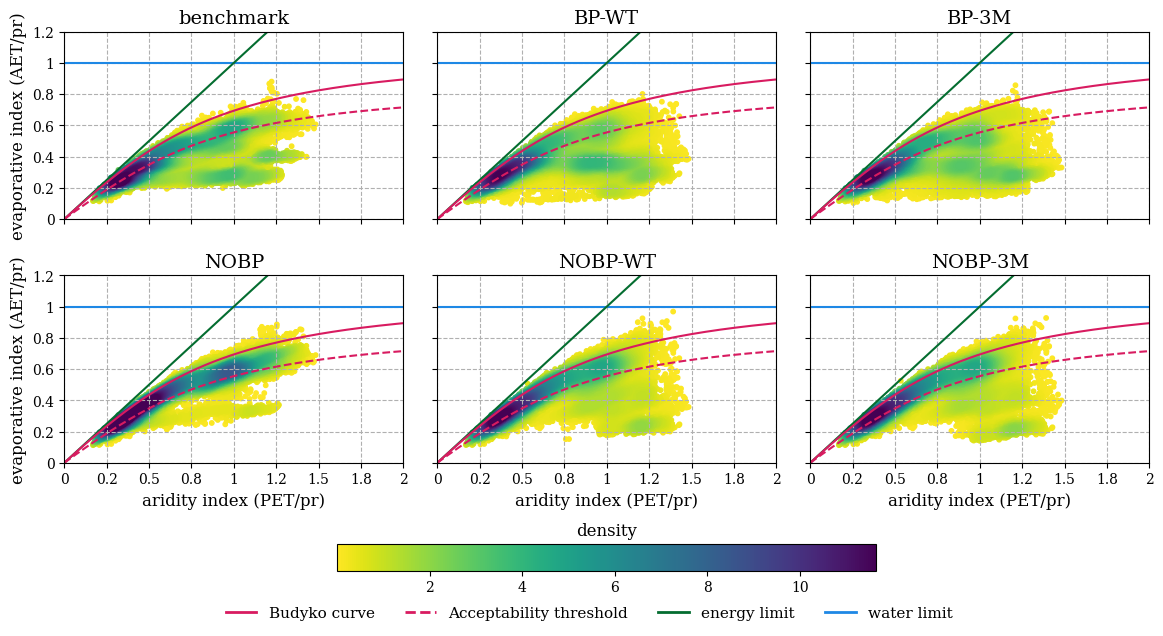

In [24]:
#bukyko plot
x_ar=np.arange(0,2,0.001)
optimal_budyko=budyko(x_ar)
cmap = plt.get_cmap("viridis_r")

mosaic=[['benchmark','BPNEWSD','BPNEWSD3'],['NOBP', 'NOBPNEWSD', 'NOBPNEWSD3']]

fig = plt.figure(figsize = (14,7))
ax=fig.subplot_mosaic(mosaic)
x=aridity_index
y='evap_ratio'

for i,e in enumerate(exp_names):
    # mask2apply=((summary_dict[e]['b_Xinanjiang'][var_name]<2)[::-1]).values & (sd_color>900)
    y_flat=flatDA(summary_dict[e]['evap_ratio'].where(mask2apply))
    xy = np.vstack([x_flat,y_flat])
    z0 = gaussian_kde(xy)(xy)
    idx = z0.argsort()
    density1=ax[e].scatter(x_flat[idx],y_flat[idx],c=z0[idx], s=10,norm=norm,cmap=cmap)
    ax[e].hlines(1,xmin=0,xmax=2, color='#1E88E5')
    ax[e].axline((0, 0), slope=1,c='#046D30')
    ax[e].plot(x_ar,optimal_budyko, color='#D81B60')
    ax[e].plot(x_ar,optimal_budyko*0.8, color='#D81B60',linestyle='--')
    ax[e].set_ylim(0,1.2)
    if e in ['NOBP','NOBPNEWSD','NOBPNEWSD3']:
        ax[e].set_xlabel("aridity index (PET/pr)",size=12)
        ax[e].xaxis.set_major_formatter(formatter)
    else: 
        ax[e].set_xlabel("")
        ax[e].set_xticklabels("")
        
        

    if e in ['NOBP','benchmark']: 
        ax[e].set_ylabel("evaporative index (AET/pr)",size=12)
        ax[e].yaxis.set_major_formatter(formatter)
    else: 
        ax[e].set_ylabel("")
        ax[e].set_yticklabels("")
        

    ax[e].grid(axis = 'y',linestyle = '--')
    ax[e].grid(axis = 'x',linestyle = '--')
    ax[e].set_title(exp_title[i],size=14)
sm =  ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])
# ax['NULL'].axis('off')
plt.subplots_adjust(wspace=0.1,hspace=0.3);
cbar = fig.colorbar(sm, ax=[ax[i] for i in exp_names],location ='bottom', fraction=0.05)
cbar.ax.set_title("density")

# line legend
legend_elements = [
    Line2D([0], [0], color='#D81B60', lw=2, label='Budyko curve'),
    Line2D([0], [0], color='#D81B60', linestyle='--', lw=2, label='Acceptability threshold'),
    Line2D([0], [0], color='#046D30', linestyle='-', lw=2, label='energy limit'),
    Line2D([0], [0], color='#1E88E5', linestyle='-', lw=2, label='water limit')
]
# Add legend to one of the subplots, e.g., the first
# plt.subplots_adjust(wspace=0.1, hspace=0.3, bottom=0.25)

# Place the global legend to the right of the colorbar
fig.legend(handles=legend_elements,
           loc='lower center',
           bbox_to_anchor=(0.5, 0.02),  # Adjust x-position as needed
           ncol=4,
           fontsize=11,
           frameon=False)
for i,e in enumerate(exp_names):
    ax[e].set_ylim(0,1.2)
    ax[e].set_xlim(0,2)

fig.savefig(os.path.join(out_dir,'budyko_ET_density.png'), bbox_inches="tight")


0.005430987397421285
4.966433839579682


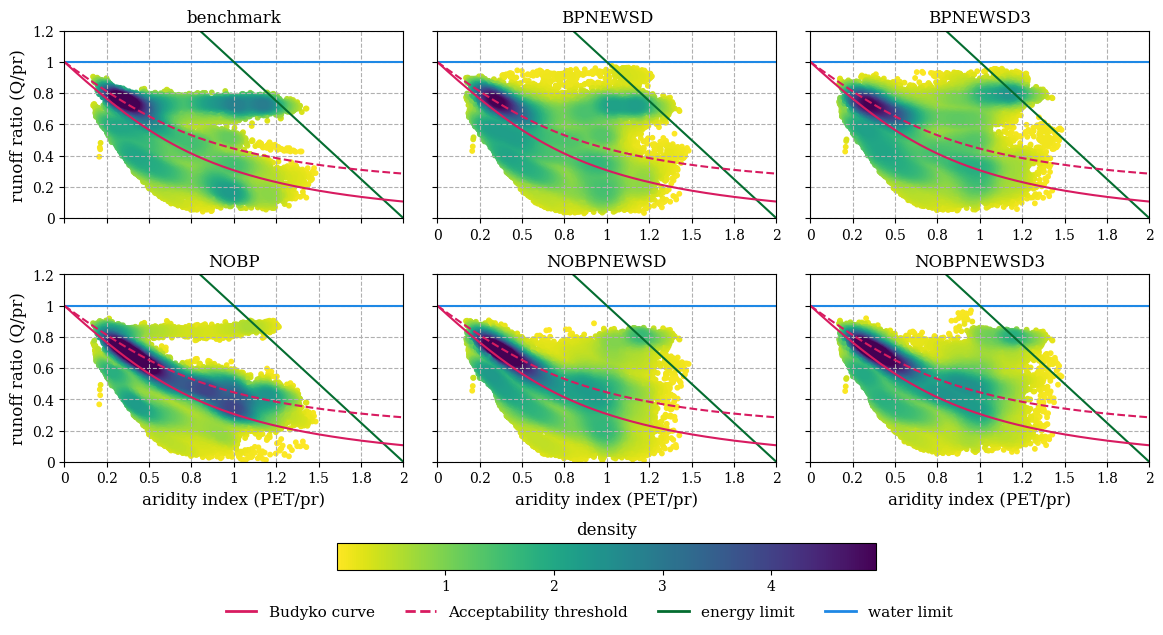

In [25]:

#bukyko plot

if 'zmin' in locals(): del zmin,zmax
cmap = plt.get_cmap("viridis_r")

mosaic=[['benchmark','BPNEWSD','BPNEWSD3'],['NOBP', 'NOBPNEWSD', 'NOBPNEWSD3']]

fig = plt.figure(figsize = (14,7))
ax=fig.subplot_mosaic(mosaic)
x=aridity_index
y='runoff_ratio'

aridity_index_exp=et_mean/summary_dict[e]['prec_net']
ttoc_ratio_pr=summary_dict[e]['ttoc_ratio'].where(mask2apply)
for i,e in enumerate(exp_names):

    # mask2apply=((summary_dict[e]['b_Xinanjiang'][var_name]<2)[::-1]).values & (sd_color>900)
    mask2apply=condition_sealed
    x_flat=flatDA(aridity_index.where(mask2apply))
    y_flat=flatDA(summary_dict[e]['ttoc_ratio'].where(mask2apply))
    xy = np.vstack([x_flat,y_flat])
    zmin_t= (gaussian_kde(xy)(xy)).min()
    zmax_t=(gaussian_kde(xy)(xy)).max()
    if 'zmin' in locals():
        zmin=min(zmin,zmin_t)
        zmax=min(zmax,zmax_t)
    else: 
        zmin=zmin_t
        zmax=zmax_t
print(zmin)
print(zmax)
norm = Normalize(zmin, zmax)
for i,e in enumerate(exp_names):

    # mask2apply=((summary_dict[e]['b_Xinanjiang'][var_name]<2)[::-1]).values & (sd_color>900)
    mask2apply=condition_sealed
    x_flat=flatDA(aridity_index.where(mask2apply))
    y_flat=flatDA(summary_dict[e]['ttoc_ratio'].where(mask2apply))
    xy = np.vstack([x_flat,y_flat])
    z0 = gaussian_kde(xy)(xy)
    idx = z0.argsort()
    density1=ax[e].scatter(x_flat[idx],y_flat[idx],c=z0[idx], s=10,norm=norm,cmap=cmap)
    ax[e].hlines(1,xmin=0,xmax=2, color='#1E88E5')
    ax[e].axline((1, 1), slope=-1,c='#046D30')
    ax[e].plot(x_ar,1-optimal_budyko, color='#D81B60')
    ax[e].plot(x_ar,1-optimal_budyko*0.8, color='#D81B60',linestyle='--')
    ax[e].set_ylim(0,1.2)
    if e in ['NOBP','NOBPNEWSD','NOBPNEWSD3']:
        ax[e].set_xlabel("aridity index (PET/pr)",size=12)
        ax[e].xaxis.set_major_formatter(formatter)
    else: 
        ax[e].set_xlabel("")
        ax[e].set_xticklabels("")
        ax[e].yaxis.set_major_formatter(formatter)

    if e in ['NOBP','benchmark']: 
        ax[e].set_ylabel("runoff ratio (Q/pr)",size=12)
        ax[e].yaxis.set_major_formatter(formatter)
    else: 
        ax[e].set_ylabel("")
        ax[e].set_yticklabels("")
        ax[e].xaxis.set_major_formatter(formatter)

    ax[e].grid(axis = 'y',linestyle = '--')
    ax[e].grid(axis = 'x',linestyle = '--')
    ax[e].set_title(e,size=14)

    ax[e].set_title(e)
sm =  ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])


plt.subplots_adjust(wspace=0.1,hspace=0.3);
cbar = fig.colorbar(sm, ax=[ax[i] for i in exp_names],location ='bottom', fraction=0.05)
cbar.ax.set_title("density")

# line legend
legend_elements = [
    Line2D([0], [0], color='#D81B60', lw=2, label='Budyko curve'),
    Line2D([0], [0], color='#D81B60', linestyle='--', lw=2, label='Acceptability threshold'),
    Line2D([0], [0], color='#046D30', linestyle='-', lw=2, label='energy limit'),
    Line2D([0], [0], color='#1E88E5', linestyle='-', lw=2, label='water limit')
]
# Add legend to one of the subplots, e.g., the first
# plt.subplots_adjust(wspace=0.1, hspace=0.3, bottom=0.25)

# Place the global legend to the right of the colorbar
fig.legend(handles=legend_elements,
           loc='lower center',
           bbox_to_anchor=(0.5, 0.02),  # Adjust x-position as needed
           ncol=4,
           fontsize=11,
           frameon=False)
for i,e in enumerate(exp_names):
    ax[e].set_ylim(0,1.2)
    ax[e].set_xlim(0,2)
# legend1 = ax[0].legend(loc='center', bbox_to_anchor=(1,-0.15))
# ax[0].colorbar()
# legend = ax[1].legend(loc='center', bbox_to_anchor=(1,-0.15))
# ax[1].add_artist(legend)
fig.savefig(os.path.join(out_dir,'budyko_RUNOFF_density.png'), bbox_inches="tight")


Compute relative distance from Budyko AET and Budyko runoff

In [26]:
# relative distance from budyko evap
exp_evap=budyko(aridity_index)

for e in exp_names:

    dist_abs=abs((exp_evap-summary_dict[e]['evap_ratio'])/exp_evap)
    dist=(exp_evap-summary_dict[e]['evap_ratio'])/exp_evap
    summary_dict[e].update({'dist_perc_abs':dist_abs})
    summary_dict[e].update({'dist_perc':dist})
    summary_dict[e].update({'dist':abs(exp_evap-summary_dict[e]['evap_ratio'])})



In [27]:
# distance from budyko ttoc
exp_ttoc=1-budyko(aridity_index)

for e in exp_names:

    dist_abs=abs((exp_ttoc-summary_dict[e]['ttoc_ratio'])/exp_ttoc)
    dist=(exp_ttoc-summary_dict[e]['ttoc_ratio'])/exp_ttoc
    summary_dict[e].update({'dist_perc_abs_ttoc':dist_abs})
    summary_dict[e].update({'dist_perc_ttoc':dist})
v_list=['dist_perc_ttoc','dist_perc_abs_ttoc']
# for e in exp_names:
#     for v in v_list:
#         v_flat=summary_dict[e][v].values.flatten()
#         v_flat=v_flat[np.isfinite(v_flat)] 
#         v_name=v+'_flat'
#         summary_dict[e].update({v_name:v_flat})

In [28]:
exp_color=['#BD1768','#E45700','#FFD400','black','#6AABF9','#6746FF']

In [29]:
exp_names=['NOBP', 'NOBPNEWSD', 'NOBPNEWSD3', 'benchmark', 'BPNEWSD', 'BPNEWSD3']


/tmp/ipykernel_236139/1606738197.py:34: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(prop={'size': 12}, ncol=6,loc=8,bbox_to_anchor=(0, -0.25, 0, 0.45))


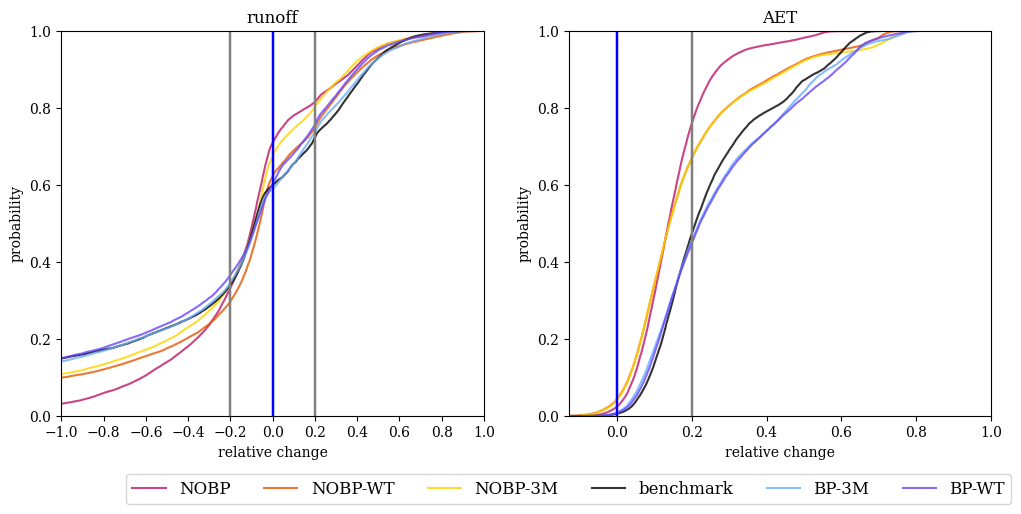

In [30]:
var2print_list=['dist_perc_ttoc', 'dist_perc']

fig = plt.figure(figsize = (12,5))
ax=fig.subplot_mosaic([var2print_list])
for i,var2print in enumerate(var2print_list): 
    for i,e in enumerate(exp_names):

        data=flatDA(summary_dict[e][var2print].where(condition_sealed))
        # print(f'{e} {var2print} {np.mean(data)}')
        exp_cdf=get_CDF_data(data)
        # if e== 'benchmark':ax['NULL'].plot(exp_cdf[0], exp_cdf[1], label=e, c='black')
        
        ax[var2print].plot(exp_cdf[0], exp_cdf[1], label=exp_title[i],color=exp_color[i],alpha=0.8)
        max_plot=max(exp_cdf[0].max(),1)
        min_plot=min(exp_cdf[0].min(),0)
        if var2print=='dist_perc_ttoc':
            ax[var2print].axis([-1, max_plot, 0, 1])
        else: 
            ax[var2print].axis([min_plot, max_plot, 0, 1])
        # ax[var2print].axis([min_plot, max_plot, 0, 1])
        ax[var2print].set_xlabel(var2print)
        ax[var2print].vlines(0,0,1,color='blue')
        ax[var2print].vlines(0.2,0,1,color='grey')
        if var2print=='dist_perc_ttoc':
            ax[var2print].vlines(-0.2,0,1,color='grey')
            ax[var2print].set_title('runoff')
            ax[var2print].set_xticks(np.arange(-1, 1.1, 0.2))
        else:
            ax[var2print].set_title('AET')
            ax[var2print].set_xticks(np.arange(0, 1.1, 0.2))

        ax[var2print].set_ylabel('probability')
        ax[var2print].set_xlabel('relative change')
        plt.legend(prop={'size': 12}, ncol=6,loc=8,bbox_to_anchor=(0, -0.25, 0, 0.45))

        fig.savefig(os.path.join(out_dir,'budyko_CDF.png'), bbox_inches="tight")

    

In [31]:
# t=summary_dict[e]['dist_perc'].to_dataset(name='budyko_dist').rio.write_crs("epsg:4326", inplace=True)
# r=t.rio.clip(catchments.geometry.values, catchments.crs, drop=False, invert=True)

Plot Water balance

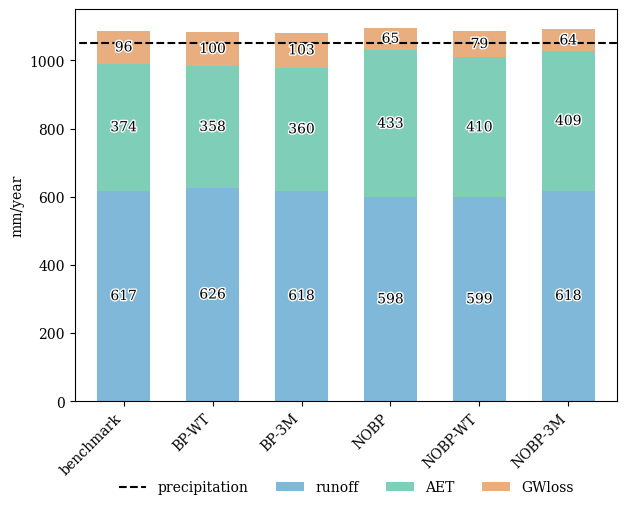

In [54]:
color=['#0072B2','#009E73','#D55E00']

# https://davidmathlogic.com/colorblind/#%23000000-%23E69F00-%2356B4E9-%23009E73-%23F0E442-%230072B2-%23D55E00-%23CC79A7
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
wb_df=pd.DataFrame(index=exp_names)
fig,ax = plt.subplots(1,1,figsize = (7,4))
wb_df=pd.DataFrame(index=exp_names)
ax.hlines(pr_mean*365,xmin=-1,xmax=10000, color='black',label='precipitation', linestyle='--')
for wbc in ['ttoc','etact','gwl']:
    wb_df[wbc]=np.nan
    for e in exp_names:
        value=summary_dict[e][wbc].mean(dim=['lat','lon'])
        wb_df.at[e,wbc]=value*365
pr_mean=pr_mean.where(~condition_lis).mean(dim=['lat','lon'])
wb_df.columns=['runoff','AET','GWloss']
wb_df=wb_df.T
wb_df.columns=['NOBP', 'NOBP-WT', 'NOBP-3M', 'benchmark', 'BP-3M', 'BP-WT']
wb_df=wb_df[[ 'benchmark', 'BP-WT','BP-3M','NOBP', 'NOBP-WT', 'NOBP-3M' ]]
wb_df.T.plot.bar(stacked=True,ax=ax,color=color,alpha=0.5,width=0.6)

# # Loop through each bar and add text
for p in ax.patches:
    # Get the height of each bar
    height = p.get_height()
    # Get the position to place the text (center of each bar's x-position)
    x_position = p.get_x() + p.get_width() / 2
    y_position = p.get_y() + height / 2
    
#     # Add text with the height value
    txt=ax.text(x_position, y_position, f'{height:.0f}', ha='center', va='center')
    txt.set_path_effects([PathEffects.withStroke(linewidth=2, foreground='w')])
ax.set_ylabel('mm/year')
plt.draw()
plt.xticks(rotation=45, ha='right')
# Set better space below the plot
fig.subplots_adjust(bottom=-0.1)

# Create a clean legend below the chart
legend1 = ax.legend(
    loc='lower center',
    bbox_to_anchor=(0.5, -0.27),  # center horizontally, closer to the bars
    ncol=4,
    frameon=False,                # optional: remove box
    title=None          # optional: legend title
)
# ax.add_artist(legend1)
# Show the plot
plt.show()

fig.savefig(os.path.join(out_dir,'water_balance.png'), bbox_inches="tight")



In [33]:
def rasterize(shapes, coords, fill=np.nan, **kwargs):
    """Rasterize a list of (geometry, fill_value) tuples onto the given
    xray coordinates. This only works for 1d latitude and longitude
    arrays.
    """
    transform = transform_from_latlon(coords['lat'], coords['lon'])
    out_shape = (len(coords['lat']), len(coords['lon']))
    raster = features.rasterize(shapes, out_shape=out_shape,
                                fill=fill, transform=transform,
                                dtype=float, **kwargs)
    return xray.DataArray(raster, coords=coords, dims=('lat', 'lon'))
import geopandas
from rasterio import features
from affine import Affine

def transform_from_latlon(lat, lon):
    lat = np.asarray(lat)
    lon = np.asarray(lon)
    trans = Affine.translation(lon[0], lat[0])
    scale = Affine.scale(lon[1] - lon[0], lat[1] - lat[0])
    return trans * scale

In [34]:
xds=summary_dict[e]['dist_perc'].to_dataset(name='budyko_dist')
xds.rio.write_crs("epsg:4326", inplace=True)
geom = catchments[['geometry', 'ID' ]].values.tolist()
fields_rasterized = features.rasterize(geom, out_shape=xds.budyko_dist.shape, transform=xds.rio.transform())

In [ ]:
for e in exp_names:
    dist=summary_dict[e]['dist_perc_abs'].where(condition_sealed)
    tot=summary_dict[e]['dist_perc_abs'].where(~condition_lis)
    summary_dict[e]['performance']['budiko_compliance']=np.nan
    summary_dict[e]['performance']['budiko_compliance_mode']=np.nan
    summary_dict[e]['performance']['bc_count']=np.nan
    summary_dict[e]['performance']['tot']=np.nan
    summary_dict[e]['performance']['sd2']=np.nan
    summary_dict[e]['performance']['sd3']=np.nan
    summary_dict[e]['performance']['sd2log10']=np.nan
    summary_dict[e]['performance']['sd3log10']=np.nan
    sd2=summary_dict[e]['sd2'].where(condition_sealed)
    sd3=summary_dict[e]['sd3'].where(condition_sealed)

    for i in KGE_df.ObsID:
        mean_dist=dist.where(fields_rasterized==i).mean()
        mode_dist=dist.where(fields_rasterized==i).median()
        mean_sd2=sd2.where(fields_rasterized==i).mean()
        mean_sd3=sd3.where(fields_rasterized==i).mean()
        mean_sd2log10=np.log10(sd2).where(fields_rasterized==i).mean()
        mean_sd3=sd3.where(fields_rasterized==i).mean()
        mean_sd3log10=np.log10(sd3).where(fields_rasterized==i).mean()

        count=dist.where(fields_rasterized==i).count()
        pixtotal=tot.where(fields_rasterized==i).count()
        summary_dict[e]['performance'].at[i,'sd2']=mean_sd2.values
        summary_dict[e]['performance'].at[i,'sd3']=mean_sd3.values
        summary_dict[e]['performance'].at[i,'sd2log10']=mean_sd2.values
        summary_dict[e]['performance'].at[i,'sd3log10']=mean_sd3.values
        # mode_dist=
        summary_dict[e]['performance'].at[i,'budiko_compliance']=mean_dist
        summary_dict[e]['performance'].at[i,'budiko_compliance_mode']=mode_dist
        summary_dict[e]['performance'].at[i,'bc_count']=count
        summary_dict[e]['performance'].at[i,'tot']=pixtotal
    
    summary_dict[e]['performance']['bc_countN']=summary_dict[e]['performance']['bc_count']/summary_dict[e]['performance']['tot']


    # sc=ax[e].scatter(summary_dict[e][x_var].where(mask),summary_dict[e][y_var].where(mask),s=1.2,alpha=0.5)
    # sc=ax[e].scatter(summary_dict[e][x_var].where(mask),forest_frac['Band1'].where(mask),s=1.2,alpha=0.5)



In [38]:
from scipy.stats import pearsonr
import pandas as pd

def calculate_pvalues(df):
    dfcols = pd.DataFrame(columns=df.columns)
    pvalues = dfcols.transpose().join(dfcols, how='outer')
    for r in df.columns:
        for c in df.columns:
            tmp = df[df[r].notnull() & df[c].notnull()]
            pvalues[r][c] = pearsonr(tmp[r], tmp[c])[1]
    return pvalues


In [ ]:
cmap='bwr'
if 'dist_cor' in locals():
    del dist_cor
wated_keys=['PowerPrefFlow','b_Xinanjiang', 'budiko_compliance', 'budiko_compliance_mode','sd2', 'sd3']
for e in exp_names:
    tempdf=summary_dict[e]['performance']
    tempdf=tempdf.drop(tempdf[tempdf.bc_countN<0.3].index)
    X=tempdf[wated_keys]
    if e in ['NOBP', 'NOBPNEWSD', 'NOBPNEWSD3']:
        X=X.drop('PowerPrefFlow',axis=1)
    cor=X.corr()
    pval=calculate_pvalues(X)
    if 'dist_cor' not in locals():
        dist_cor=cor['budiko_compliance']
        dist_pvalues=pval['budiko_compliance']
    
    else:
        dist_cor=pd.concat([dist_cor,cor['budiko_compliance']],axis=1)
        dist_pvalues=pd.concat([dist_pvalues,pval['budiko_compliance']],axis=1)


In [40]:
dist_pvalues.columns=exp_names
dist_pvalues_d=(dist_pvalues.T).drop(['budiko_compliance', 'budiko_compliance_mode'],axis=1)
dist_cor.columns=exp_names
dist_cor_d=(dist_cor.T).drop(['budiko_compliance', 'budiko_compliance_mode'],axis=1)

<Axes: >

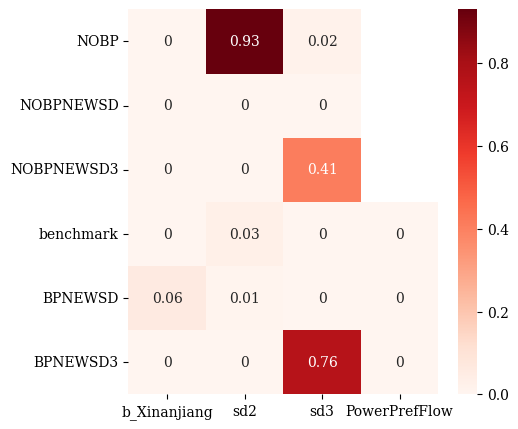

In [41]:
fig,ax = plt.subplots(1,1,figsize = (5,5))
sns.heatmap(round(dist_pvalues_d.astype(float),2),cmap='Reds',annot=True,ax=ax)

In [42]:
# fix names for paper
dist_cor_d[dist_pvalues_d>0.05]=np.nan
dist_cor_d.columns=['bInfilt','sd2','sd3','PowerPrefFlow']
dist_cor_d=dist_cor_d.T
dist_cor_d.columns=['NOBP', 'NOBP-WT', 'NOBP-3M', 'benchmark','BP-WT','BP-3M']
dist_cor_d=dist_cor_d[[ 'benchmark', 'BP-WT','BP-3M','NOBP', 'NOBP-WT', 'NOBP-3M' ]]

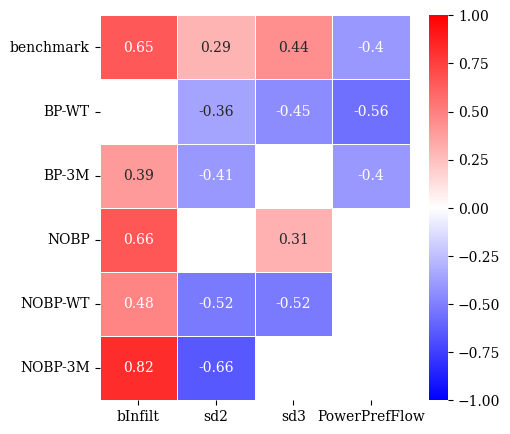

In [43]:
fig,ax = plt.subplots(1,1,figsize = (5,5))
sns.heatmap(dist_cor_d.T, vmin=-1,vmax=1,cmap=cmap,annot=True, linewidth=.5)
fig.savefig(os.path.join(out_dir,'corr_coeff.png'), bbox_inches="tight")


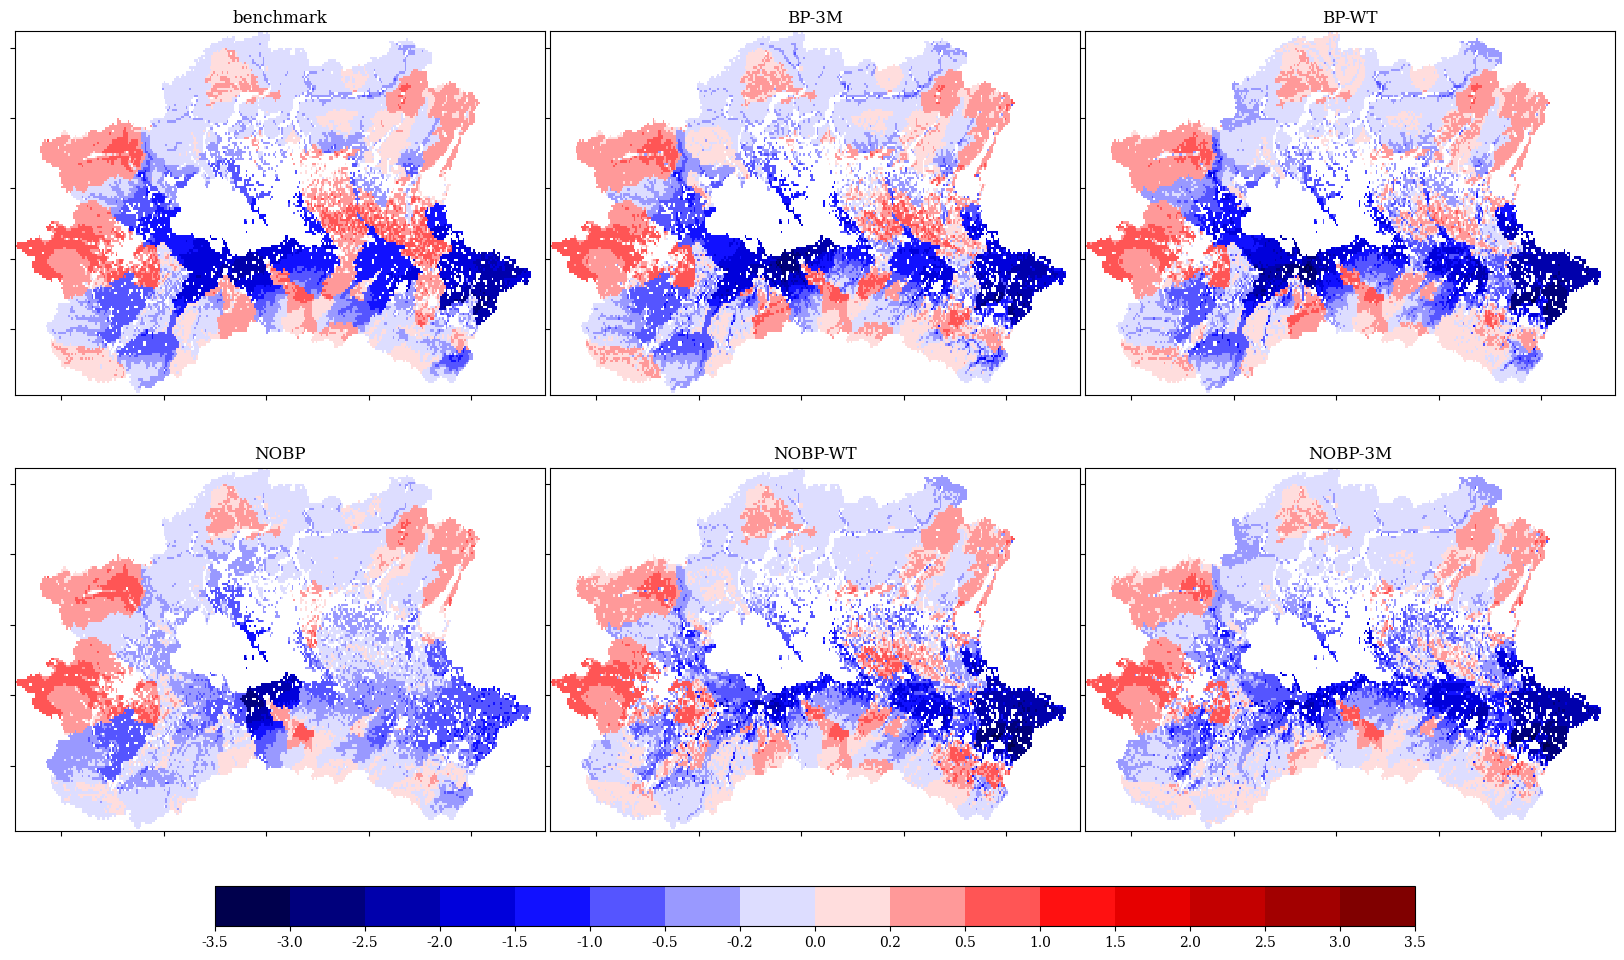

In [44]:
levels=list(np.arange(-3.5,4,0.5))
levels=[-3.5,-3.0,-2.5,-2.0,-1.5,-1.0,-0.5,-0.2,0.0,0.2,0.5,1.0,1.5,2.0,2.5,3.0,3.5]
cmap = matplotlib.cm.seismic
cmap.set_bad(color="white")
fig = plt.figure(figsize = (20,10))
ax=fig.subplot_mosaic(mosaic)

for i,e in enumerate(exp_names):

    summary_dict[e]['dist_perc_ttoc'].where(condition_sealed).isel(lon=slice(0,310),lat=slice(0,155)).plot(ax=ax[e],add_colorbar=False,cmap=cmap,levels=levels);
    ax[e].set_xlabel(''),ax[e].set_ylabel('')
    ax[e].set_xticklabels('')
    ax[e].set_yticklabels('')
    ax[e].set_title(exp_title[i]);
a=summary_dict['NOBPNEWSD']['dist_perc_ttoc'].where(condition_sealed).isel(lon=slice(0,310),lat=slice(0,155)).plot(ax=ax['NOBPNEWSD'],add_colorbar=False,cmap=cmap,levels=levels);
ax['NOBPNEWSD'].set_yticklabels('')
ax['NOBPNEWSD'].set_xticklabels('')
ax['NOBPNEWSD'].set_xlabel(''),ax['NOBPNEWSD'].set_ylabel('')
ax['NOBPNEWSD'].set_title(exp_title[1]);
cbar=fig.add_axes([0.2,0.005,0.6,0.04])

thebar = fig.colorbar(a,ax=ax['NOBPNEWSD'], ticks=levels, fraction=0.05,cax=cbar,orientation = "horizontal",pad=-1, format='%.1f')
# thebar.ax.set_yticklabels(["{:4.2f}".format(i) for i in levels]) # add the labels

fig.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.01,
                    hspace=0.2)
fig.savefig(os.path.join(out_dir,'runoff_BD_distance.png'), bbox_inches="tight")


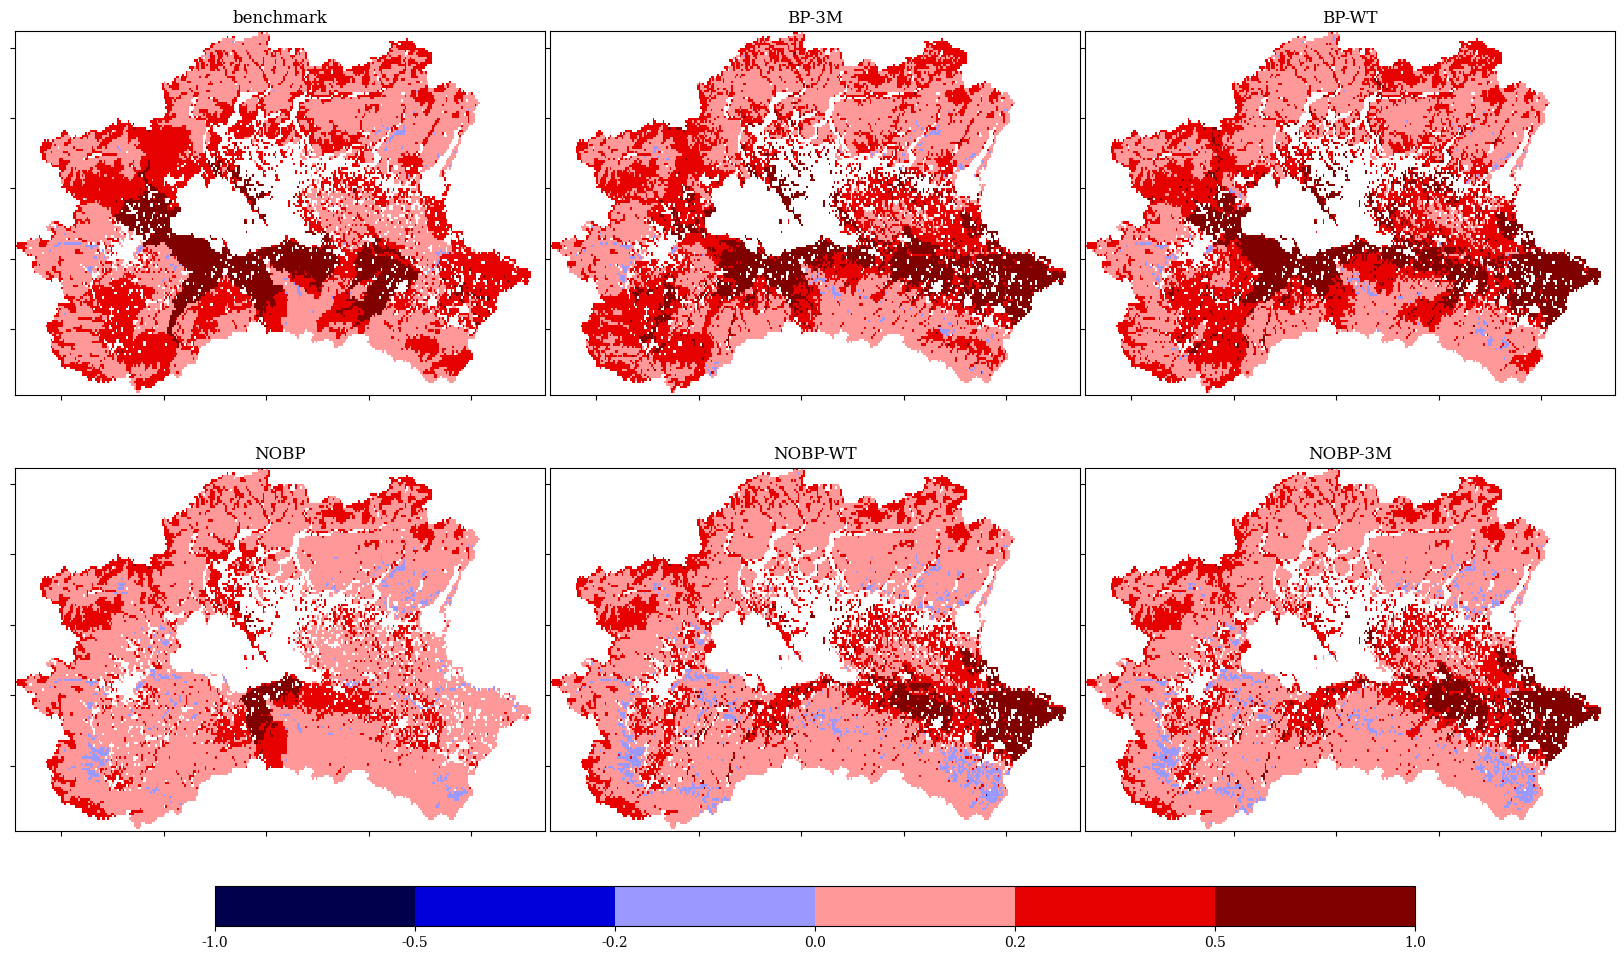

In [45]:
levels=list(np.arange(-3.5,4,0.5))
levels=[-1.0,-0.5,-0.2,0.0,0.2,0.5,1.0]
cmap = matplotlib.cm.seismic
cmap.set_bad(color="white")
fig = plt.figure(figsize = (20,10))
ax=fig.subplot_mosaic(mosaic)

for i,e in enumerate(exp_names):

    summary_dict[e]['dist_perc'].where(condition_sealed).isel(lon=slice(0,310),lat=slice(0,155)).plot(ax=ax[e],add_colorbar=False,cmap=cmap,levels=levels);
    ax[e].set_xlabel(''),ax[e].set_ylabel('')
    ax[e].set_xticklabels('')
    ax[e].set_yticklabels('')
    ax[e].set_title(exp_title[i]);
a=summary_dict['NOBPNEWSD']['dist_perc'].where(condition_sealed).isel(lon=slice(0,310),lat=slice(0,155)).plot(ax=ax['NOBPNEWSD'],add_colorbar=False,cmap=cmap,levels=levels);
ax['NOBPNEWSD'].set_yticklabels('')
ax['NOBPNEWSD'].set_xticklabels('')
ax['NOBPNEWSD'].set_xlabel(''),ax['NOBPNEWSD'].set_ylabel('')
ax['NOBPNEWSD'].set_title(exp_title[1]);
cbar=fig.add_axes([0.2,0.005,0.6,0.04])

thebar = fig.colorbar(a,ax=ax['NOBPNEWSD'], ticks=levels, fraction=0.05,cax=cbar,orientation = "horizontal",pad=-1, format='%.1f')
# thebar.ax.set_yticklabels(["{:4.2f}".format(i) for i in levels]) # add the labels

fig.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.01,
                    hspace=0.2)
fig.savefig(os.path.join(out_dir,'AET_BD_distance.png'), bbox_inches="tight")
